In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import os
import cv2
import uuid
import datetime
import numpy as np
import compress_pickle as cpkl

from ss_baselines.av_nav.config import get_config
from ss_baselines.savi.config.default import get_config as get_savi_config
from ss_baselines.common.env_utils import construct_envs
from ss_baselines.common.environments import get_env_class
from ss_baselines.common.utils import plot_top_down_map

# Helper / tools
from soundspaces.mp3d_utils import CATEGORY_INDEX_MAPPING
def get_category_name(idx):
    assert idx >= 0 and idx <=20, f"Invalid category index number: {idx}"

    for k, v in CATEGORY_INDEX_MAPPING.items():
        if v == idx:
            return k

def get_env_scene_id(envs, env_idx):
    # NOTE: might be different if using other wrapper like SYNC_ENV or VecEnv
    return envs.workers[env_idx]._env._env.current_episode.scene_id.split("/")[3]
    # return envs.workers[env_idx]._env._env._task._sim._current_scene.strip("data/scene_datasets/mp3d").split("/")[0]

def get_current_ep_category_label(obs_dict):
    return get_category_name(obs_dict["category"].argmax())

def save_episode_to_dataset(ep_data_dict, dataset_path):
    if not os.path.exists(dataset_path):
        os.mkdir(dataset_path)
    
    timestamp = datetime.datetime.now().strftime('%Y%m%dT%H%M%S')
    epid = str(uuid.uuid4().hex)
    ep_length = ep_data_dict["ep_length"]

    # TODO: consider the downside of compression if this has to be used for 
    ep_scene_id = ep_data_dict["scene_id"]
    ep_category_name = ep_data_dict["category_name"]

    ep_data_filename = f"{ep_scene_id}-{ep_category_name}-{ep_length}-{timestamp}-{epid}.bz2"
    ep_data_fullpath = os.path.join(dataset_path, ep_data_filename)
    with open(ep_data_fullpath, "wb") as f:
        cpkl.dump(ep_data_dict, f)

/home/rousslan/anaconda3/envs/ss-hab-headless-py39/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Configure the environments for data collection

In [2]:
config = get_savi_config(
    # config_paths="ss_baselines/av_nav/config/audionav/mp3d/env_test_0.yaml", # RGB + AudiogoalSensor
    config_paths="env_configs/savi/savi_ss1.yaml")
config.defrost()
## Seed override
config.SEED = config.TASK_CONFIG.SEED = config.TASK_CONFIG.SIMULATOR.SEED = 101
config.NUM_PROCESSES = 1
config.USE_SYNC_VECENV = True
config.USE_VECENV = False

## Override semantic object sensor sizes: does RGB / Depth sensor's shape increase ?
# config.DISPLAY_RESOLUTION = 512
# config.TASK_CONFIG.TASK.SEMANTIC_OBJECT_SENSOR.HEIGHT = 512
# config.TASK_CONFIG.TASK.SEMANTIC_OBJECT_SENSOR.WIDTH = 512

# For custom resolution, disable the use of pre-rendered observations
config.TASK_CONFIG.SIMULATOR.USE_RENDERED_OBSERVATIONS = False
# For smoother video, set CONTINUOUS_VIEW_CHANGE to True, and get the additional frames in obs_dict["intermediate"]
config.TASK_CONFIG.SIMULATOR.CONTINUOUS_VIEW_CHANGE = False

config.TASK_CONFIG.SIMULATOR.RGB_SENSOR.WIDTH = 512
config.TASK_CONFIG.SIMULATOR.RGB_SENSOR.HEIGHT = 512
config.TASK_CONFIG.SIMULATOR.DEPTH_SENSOR.WIDTH = 512
config.TASK_CONFIG.SIMULATOR.DEPTH_SENSOR.HEIGHT = 512

# Add support for TOP_DOWN_MAP
config.TASK_CONFIG.TASK.MEASUREMENTS.append("TOP_DOWN_MAP")
config.freeze()
# print(config)

print(config)

BASE_TASK_CONFIG_PATH: env_configs/savi/base_semantic_audiogoal.yaml
CHECKPOINT_FOLDER: data/models/output/data
CHECKPOINT_INTERVAL: 50
CMD_TRAILING_OPTS: []
CONTINUOUS: False
DEBUG: False
DISPLAY_RESOLUTION: 128
ENV_NAME: AudioNavRLEnv
EVAL:
  SPLIT: val
  USE_CKPT_CONFIG: True
EVAL_CKPT_PATH_DIR: data/models/output/data
EXTRA_RGB: False
LOG_FILE: data/models/output/train.log
LOG_INTERVAL: 10
MODEL_DIR: data/models/output
NUM_PROCESSES: 1
NUM_UPDATES: 20000
RL:
  DDPPO:
    backbone: custom_resnet18
    distrib_backend: GLOO
    num_recurrent_layers: 1
    pretrained: True
    pretrained_weights: data/models/savi/data/ckpt.XXX.pth
    reset_critic: False
    rnn_type: GRU
    sync_frac: 0.6
  DISTANCE_REWARD_SCALE: 1.0
  PPO:
    BELIEF_PREDICTOR:
      audio_only: False
      current_pred_only: False
      lr: 0.001
      normalize_category_distribution: False
      online_training: True
      train_encoder: False
      use_label_belief: True
      use_location_belief: True
      wei

### Instantiate the environments

In [3]:
envs = construct_envs(config, get_env_class(config.ENV_NAME))

2023-05-18 13:20:23,896 Initializing dataset SemanticAudioNav
2023-05-18 13:20:23,907 Initializing dataset SemanticAudioNav
2023-05-18 13:21:05,208 initializing sim SoundSpacesSim
2023-05-18 13:21:24,781 Initializing task SemanticAudioNav


[13:21:05:242889]:[Metadata] AttributesManagerBase.h(380)::createFromJsonOrDefaultInternal : <Dataset>: Proposing JSON name : default.scene_dataset_config.json from original name : default| This file does not exist.
[13:21:05:243003]:[Metadata] AssetAttributesManager.cpp(121)::createObject : Asset attributes (capsule3DSolid:capsule3DSolid_hemiRings_4_cylRings_1_segments_12_halfLen_0.75_useTexCoords_false_useTangents_false) created and registered.
[13:21:05:243040]:[Metadata] AssetAttributesManager.cpp(121)::createObject : Asset attributes (capsule3DWireframe:capsule3DWireframe_hemiRings_8_cylRings_1_segments_16_halfLen_1) created and registered.
[13:21:05:243065]:[Metadata] AssetAttributesManager.cpp(121)::createObject : Asset attributes (coneSolid:coneSolid_segments_12_halfLen_1.25_rings_1_useTexCoords_false_useTangents_false_capEnd_true) created and registered.
[13:21:05:243086]:[Metadata] AssetAttributesManager.cpp(121)::createObject : Asset attributes (coneWireframe:coneWireframe_s

### Dataset parameterization

In [4]:
DATASET_TOTAL_STEPS = 50
DATASET_DIR_PATH = f"SAVI_Oracle_Dataset_2023_05_17__{DATASET_TOTAL_STEPS}__STEPS"

NUM_ENVS = config.NUM_PROCESSES

### Data collection

In [5]:
# Placeholders for episode data
obs_list, \
reward_list, \
done_list, \
info_list, \
action_list = \
    [[] for _ in range(NUM_ENVS)], \
    [[] for _ in range(NUM_ENVS)], \
    [[] for _ in range(NUM_ENVS)], \
    [[] for _ in range(NUM_ENVS)], \
    [[] for _ in range(NUM_ENVS)]
# Plaecholders for various statistics about the training data
dataset_statistics = {
    "action_counts": {i: 0 for i in range(4)},
    "total_steps": 0,
    "total_episodes": 0,
    "scene_counts": {},
    "category_counts": {get_category_name(i): 0 for i in range(21)} # 21 categories in SAVi.
}

obs, done = envs.reset(), [False for _ in range(NUM_ENVS)]

step = 0
ep_returns = []
envs_current_step = [0 for _ in range(NUM_ENVS)]

while step < DATASET_TOTAL_STEPS:
    # Recover the optimal action for each parallel env
    actions = [envs.workers[i]._env._env._sim._oracle_actions[envs_current_step[i]] for i in range(NUM_ENVS)]

    # Step the environment
    outputs = envs.step(actions)
    next_obs, reward, next_done, info = [list(x) for x in zip(*outputs)]

    # Recorder episode trajectoreis
    for i in range(NUM_ENVS):
        obs_list[i].append(obs[i])
        done_list[i].append(done[i])
        action_list[i].append(actions[i])
        reward_list[i].append(reward[i])
        info_list[i].append(info[i])

    # When one or more episode end is detected, write to disk,
    # then reset the placeholders for the finished env. idx
    if np.sum(next_done) >= 1.:
        finished_envs_idxs = np.where(next_done)[0]
    
        for i in finished_envs_idxs:
            if not info_list[i][-1]["success"] == 1:
                continue
        
            ep_length = len(obs_list[i])
            ep_returns = []
            ep_success = []
            ep_norm_dist_to_goal = []

            # Pre-process the obs_dict to have lists of "rgb", "depth", etc..
            obs_dict = {k: [] for k in obs_list[i][0].keys()} # TODO: to also store intermediate, maaybe use obs_list[i][1].keys() instead

            # Stores the high resolution rgb and depth data
            highres_obs_list = {k: [] for k in ["rgb", "depth"]}

            for t in range(ep_length):
                for k, v in obs_list[i][t].items():
                    if k in ["rgb", "depth"]:
                        highres_obs_list[k].append(v.copy()) # TODO: make sure the high res stuff is not resized later
                        obs_dict[k].append(cv2.resize(v, dsize=(128, 128)))
                    else:
                        obs_dict[k].append(v)
                
                # Count actions for overall dataset statistics
                dataset_statistics["action_counts"][action_list[i][t]] += 1
            
            # Additional episode metadata
            # TODO: episode's scene SPLIT
            ep_scene_id = get_env_scene_id(envs, i)
            ep_category_idx = obs_dict["category"][0].argmax()
            ep_category_name = get_category_name(ep_category_idx)

            ep_data_dict = {
                "obs_list": obs_dict, # RGB and DEPTH shape (128, 128, 3)
                "highres_obs_list": highres_obs_list, # RGB and DEPTH shape (512, 512, 3)
                "action_list": action_list[i],
                "done_list": done_list[i],
                "reward_list": reward_list[i],
                "info_list": info_list[i], # This can arguably be skipped ?,
                "ep_length": ep_length,
                # Other metadata
                "scene_id": ep_scene_id,
                "category_idx": ep_category_idx,
                "category_name": ep_category_name
            }

            ep_returns.append(np.sum(reward_list[i]))
            # TODO: double check why the last info list is not the final one
            ep_success.append(info_list[i][-1]["success"])
            ep_norm_dist_to_goal.append(info_list[i][-1]["normalized_distance_to_goal"])

            # Saves to disk
            save_episode_to_dataset(ep_data_dict, DATASET_DIR_PATH)

            step += ep_length

            # Track overall statistics of the dataset
            dataset_statistics["total_episodes"] += 1
            dataset_statistics["total_steps"] += ep_length
            dataset_statistics["category_counts"][ep_category_name] += 1
            if ep_scene_id not in dataset_statistics["scene_counts"].keys():
                dataset_statistics["scene_counts"][ep_scene_id] = 1
            else:
                dataset_statistics["scene_counts"][ep_scene_id] += 1

            # Reset the data placeholders
            obs_list[i], action_list[i], done_list[i], reward_list[i], info_list[i] = \
                [], [], [], [], []
        
            # Save the dataset statistics to file
            ## Compute action probs
            dataset_statistics["action_probs"] = {
                a: dataset_statistics["action_counts"][a] / dataset_statistics["total_steps"] for a in range(4)
            }
            dataset_statistics["action_cel_coefs"] = {
                k: (0.25 / v) if v > 0 else 0. for k, v in dataset_statistics["action_probs"].items()
            }
            ## Compute action coefficient for CEL of BC
            dataset_stats_filename = "dataset_statistics.bz2"
            dataset_stats_filepath = f"{DATASET_DIR_PATH}/{dataset_stats_filename}"
            with open(dataset_stats_filepath, "wb") as f:
                cpkl.dump(dataset_statistics, f)

            for k, v in dataset_statistics.items():
                print(f"{k}: {v}")

            print("")
            print("#####################################################################################")
            print("#####################################################################################")
            print(f"Collected {step} / {DATASET_TOTAL_STEPS}; Avg return: {np.mean(ep_returns):0.2f}; Avg Suc.: {np.mean(ep_success)}; Avg: Norm Dist Goal: {np.mean(ep_norm_dist_to_goal)}")
            print("#####################################################################################")
            print("#####################################################################################")
            print("")

            
    # Prepare for the next step
    obs = next_obs
    done = next_done

    for i in range(NUM_ENVS):
        envs_current_step[i] = int((1 - next_done[i]) * (envs_current_step[i] + 1))

    # Stop collection ASAP
    if step >= DATASET_TOTAL_STEPS:
        break

[13:21:25:694478]:[Sensor] AudioSensor.cpp(81)::setAudioSourceTransform : [Audio]  Setting the audio source position :  Vector(6.61929, 1.49852, -8.9287) ]
[13:21:25:694603]:[Sensor] AudioSensor.cpp(169)::setAudioMaterialsJSON : Set audio materials database to json file :  data/mp3d_material_config.json
[13:21:25:925206]:[Sensor] AudioSensor.cpp(90)::setAudioListenerTransform : [Audio]  Setting the agent transform : position [ Vector(0.753432, 1.51127, 3.0037) ], rotQuat[ Vector(1, 0, 2.45858e-05, 0) ]
[13:21:25:925350]:[Sensor] AudioSensor.cpp(278)::createAudioSimulator : [Audio]  Create audio simulator iteration:  0
[13:21:25:926105]:[Sensor] AudioSensor.cpp(114)::runSimulation : [Audio]  Running the audio simulator
[13:21:25:926142]:[Sensor] AudioSensor.cpp(119)::runSimulation : [Audio]  New initialization, will upload geometry and add the source at position :  Vector(6.61929, 1.49852, -8.9287)
[13:21:25:926183]:[Sensor] AudioSensor.cpp(126)::runSimulation : [Audio]  Loading semanti

## Checking dataset statistics

In [6]:
with open(dataset_stats_filepath, "rb") as f:
    r__dataset_stats = cpkl.load(f)

In [7]:
r__dataset_stats

{'action_counts': {0: 2, 1: 41, 2: 4, 3: 8},
 'total_steps': 55,
 'total_episodes': 2,
 'scene_counts': {'p5wJjkQkbXX': 2},
 'category_counts': {'chair': 0,
  'table': 0,
  'picture': 0,
  'cabinet': 1,
  'cushion': 1,
  'sofa': 0,
  'bed': 0,
  'chest_of_drawers': 0,
  'plant': 0,
  'sink': 0,
  'toilet': 0,
  'stool': 0,
  'towel': 0,
  'tv_monitor': 0,
  'shower': 0,
  'bathtub': 0,
  'counter': 0,
  'fireplace': 0,
  'gym_equipment': 0,
  'seating': 0,
  'clothes': 0},
 'action_probs': {0: 0.03636363636363636,
  1: 0.7454545454545455,
  2: 0.07272727272727272,
  3: 0.14545454545454545},
 'action_cel_coefs': {0: 6.875, 1: 0.33536585365853655, 2: 3.4375, 3: 1.71875}}

## Checking collected trajectories

In [8]:
# ep_filepath = "./SAVI_Oracle_Dataset_2023_05_17__200__STEPS/VzqfbhrpDEA-cushion-23-20230517T142613-02f36c1bee3d4baaadc10c1bca0bd7e3.bz2"

# with open(ep_filepath, "rb") as f:
#     edd = cpkl.load(f)

# print(f"edd content: {list(edd.keys())}")
# edd["obs_list"].keys() # dict_keys(['depth', 'rgb', 'audiogoal', 'spectrogram', 'category', 'pointgoal_with_gps_compass', 'pose'])
# type(edd["obs_list"]["rgb"]), len(edd["obs_list"]["rgb"]), edd["obs_list"]["rgb"][0].shape

Ep. scene: p5wJjkQkbXX | Cat. : cabinet | Len. : 26
Ep. scene: kEZ7cmS4wCh | Cat. : counter | Len. : 55
Ep. scene: kEZ7cmS4wCh | Cat. : counter | Len. : 55
Ep. scene: p5wJjkQkbXX | Cat. : cushion | Len. : 29


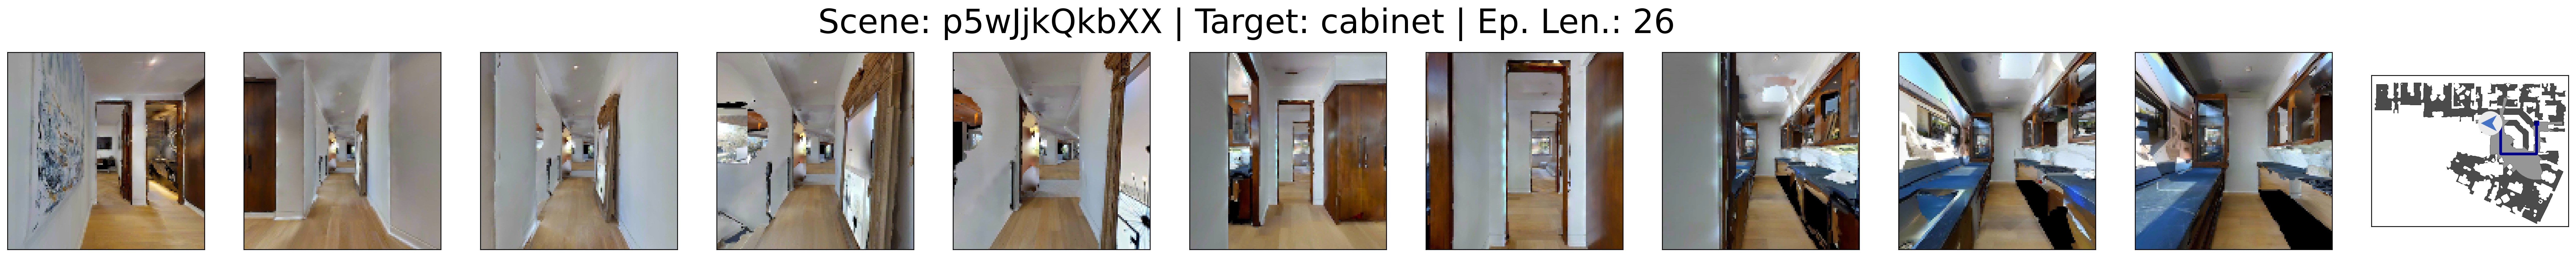

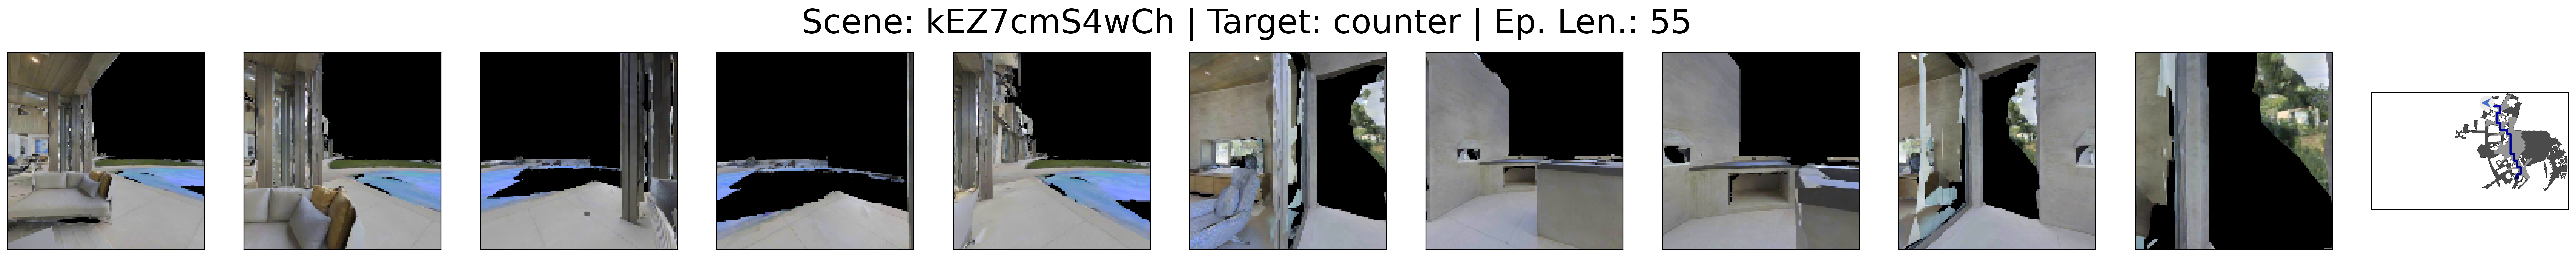

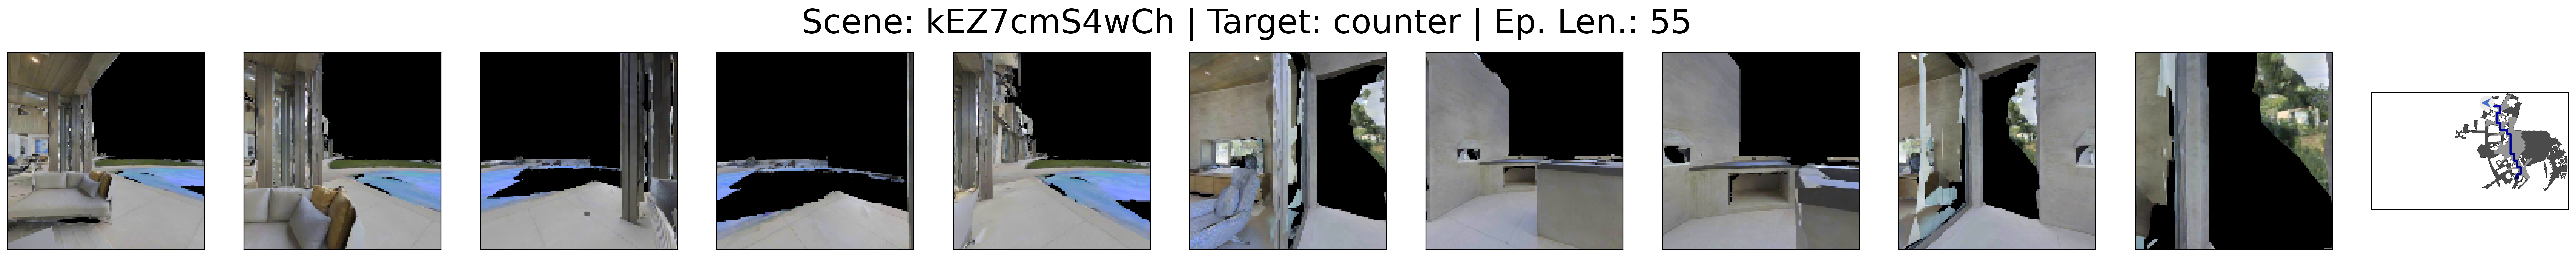

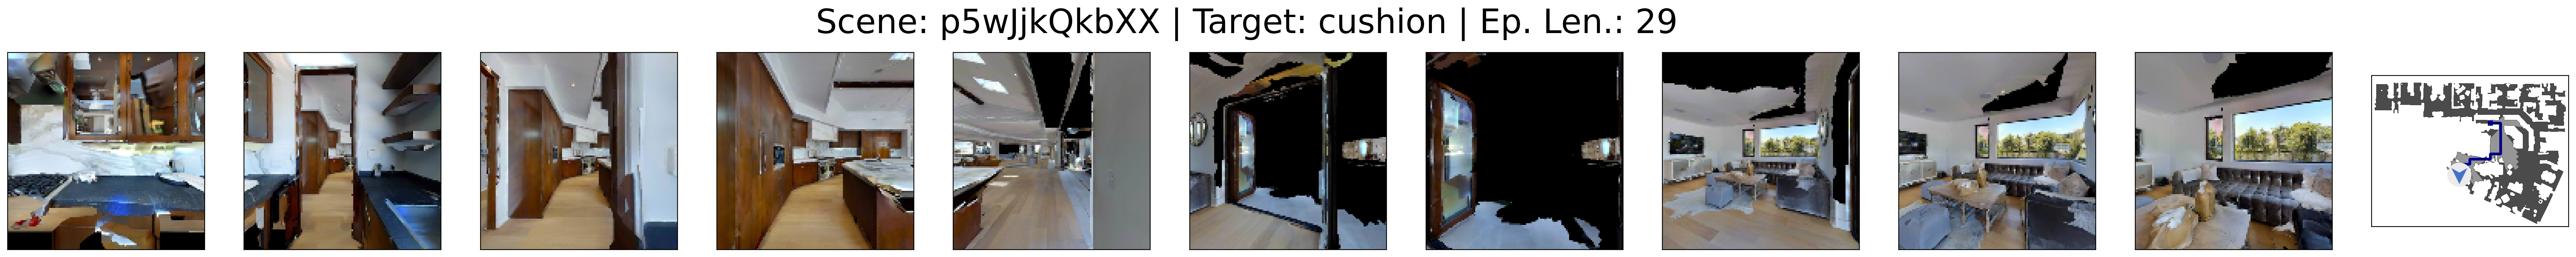

In [9]:
DATASET_PATH="SAVI_Oracle_Dataset_2023_05_17__50__STEPS"
for ep_filename in os.listdir(DATASET_PATH)[:5]:
    if ep_filename == "dataset_statistics.bz2":
        continue
    
    # relative file path
    ep_filepath = f"{DATASET_PATH}/{ep_filename}"
    
    # Load the episode data
    with open(ep_filepath, "rb") as f:
        edd = cpkl.load(f)

    ## Plot the collected trajectory's RGB observations
    ep_length = len(edd["obs_list"]["rgb"])
    ep_category_name = edd["category_name"]
    ep_scene_id = edd["scene_id"]

    print(f"Ep. scene: {ep_scene_id} | Cat. : {ep_category_name} | Len. : {ep_length}")

    N = 5
    truncated_obs_list = edd["obs_list"]["rgb"][:N] + edd["obs_list"]["rgb"][-N:]

    fig, axes = plt.subplots(1, N * 2 + 1, figsize=(4 * N * 2 + 4, 4), dpi=300)
    fig.set_facecolor("white")

    for t, rgb_obs in enumerate(truncated_obs_list):
        axes[t].tick_params(axis="both", which="both", bottom=False, top=False, left=False, labelleft=False, labelbottom=False)
        axes[t].imshow(rgb_obs)
    top_down_map_img = plot_top_down_map(edd["info_list"][-1])
    axes[-1].imshow(top_down_map_img)
    axes[-1].tick_params(axis="both", which="both", bottom=False, top=False, left=False, labelleft=False, labelbottom=False)

    fig.suptitle(f"Scene: {ep_scene_id} | Target: {ep_category_name} | Ep. Len.: {ep_length}", fontsize=32)